Calculating The Pixel Scale in Parsecs:

In [ ]:
from astropy.io import fits
from astropy import units as u
import os
from regions import Region
#Using for loop to open all the fits files in the current directory
z= 0.016268

ch_num= ['ch1','ch2','ch3','ch4']
part=['short','medium','long']

file_paths=[]
for ch in ch_num:
    for p in part:
        file_path = f'./jw01328-c1006_t014_miri_{ch}-{p}_s3d.fits'
        if os.path.exists(file_path):
            file_paths.append(file_path)
print(len(file_paths))


12


To Open the SCI extension header for all fits

In [8]:
from astropy.cosmology import Planck18 as cosmo
#Redshift value
z= 0.016268
for file_path in file_paths:
    with fits.open(file_path) as hdul:
        hdr= hdul['SCI'].header
        cdelt1=abs(hdr.get('CDELT1', 0))
        cdelt2=abs(hdr.get('CDELT2', 0))
        print(f"{file_path}")
        print(f"  CDELT1: {cdelt1} arcsec/pixel")
        print(f"  CDELT2: {cdelt2} arcsec/pixel")

        #To convert to Pasec/pixel
        #Coverting 1 arcsec to angular diameter in Mpc
        ang_diam= cosmo.angular_diameter_distance(z).to(u.pc)

        cdelt1_psec= (cdelt1*u.arcsec).to(u.rad)*ang_diam
        cdelt2_psec= (cdelt2*u.arcsec).to(u.rad)*ang_diam
        print(f'for {file_path} CDELT1 and CDELT2 values in parsec/pixel are: {cdelt1_psec}, {cdelt2_psec}, respectively')


./jw01328-c1006_t014_miri_ch1-short_s3d.fits
  CDELT1: 3.61111097865634e-05 arcsec/pixel
  CDELT2: 3.61111097865634e-05 arcsec/pixel
for ./jw01328-c1006_t014_miri_ch1-short_s3d.fits CDELT1 and CDELT2 values in parsec/pixel are: 0.012370094745285458 pc rad, 0.012370094745285458 pc rad, respectively
./jw01328-c1006_t014_miri_ch1-medium_s3d.fits
  CDELT1: 3.61111097865634e-05 arcsec/pixel
  CDELT2: 3.61111097865634e-05 arcsec/pixel
for ./jw01328-c1006_t014_miri_ch1-medium_s3d.fits CDELT1 and CDELT2 values in parsec/pixel are: 0.012370094745285458 pc rad, 0.012370094745285458 pc rad, respectively
./jw01328-c1006_t014_miri_ch1-long_s3d.fits
  CDELT1: 3.61111097865634e-05 arcsec/pixel
  CDELT2: 3.61111097865634e-05 arcsec/pixel
for ./jw01328-c1006_t014_miri_ch1-long_s3d.fits CDELT1 and CDELT2 values in parsec/pixel are: 0.012370094745285458 pc rad, 0.012370094745285458 pc rad, respectively
./jw01328-c1006_t014_miri_ch2-short_s3d.fits
  CDELT1: 4.72222227189275e-05 arcsec/pixel
  CDELT2: 4.72

All three parts(short, medium, long) have same pixel scale for parsec.
If we take average of those values it's 0.020220347 pc rad.

        Each region file contains two regions.
        Starting from indexing 0 each channel contributes six spectra 3 exposures*2 regions.

In [ ]:
from regions import Regions
import pandas as pd
import numpy as np
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import warnings

#Each region file contains 2 regions, one for each exposure and channel
z= 0.016268
channels=[1,2,3,4]
part1=['short','medium','long']

#base_path = './MAST_NGC_7469/'
region_path = './regions/'

spectrum_all = []        # List of spectra for all regions
spectrum_all_err = []    # List of errors for all regions
wavelength_all = []      # List of wavelengths for each spectrum


for ch in channels:
    for part in part1:
        fits_file = f"jw01328-c1006_t014_miri_ch{ch}-{part}_s3d.fits"
        reg_file= f"ch{ch}-{part}.reg"

        regions = Regions.read(reg_file, format='ds9')

        #Extractinge the data from the fits file
        hdul =fits.open(fits_file)
        data =hdul[1].data
        data[data < 0]= np.nan
        data_err =hdul[2].data
        header= hdul[1].header
        wcs =WCS(header)

        # Wavelength axis
        n_wavelengths= data.shape[0]
        crval3= header['CRVAL3']
        cdelt3= header['CDELT3']
        crpix3= header['CRPIX3']
        wavelength= (np.arange(n_wavelengths)-(crpix3-1))*cdelt3+crval3
        wavelength= wavelength/(1+z) 


        for i, region in enumerate(regions):  #region 0(Center Region) & region 1(Ring Region)
            spectrum = []
            spectrum_err = []

            mask = region.to_pixel(wcs.celestial).to_mask()
            num_channels, ny, nx = data.shape


            for k in range(num_channels):
                masked_data =np.array(mask.multiply(data[k, :, :]), dtype=float)
                masked_data_err =np.array(mask.multiply(data_err[k, :, :]),dtype=float)

                avg_intensity =np.nanmean(masked_data)
                avg_intensity_err =np.sqrt(np.nanmean(masked_data_err**2))

                
                if np.isnan(avg_intensity):
                    avg_intensity =0
                if np.isnan(avg_intensity_err):
                    avg_intensity_err =0

                spectrum.append(avg_intensity)
                spectrum_err.append(avg_intensity_err)

            
            wavelength_all.append(wavelength)
            spectrum_all.append(spectrum)
            spectrum_all_err.append(spectrum_err)

            dfr = pd.DataFrame({
                "wavelength_microns": wavelength,
                "Spectrum": spectrum,
                "Spectrum_err": spectrum_err,
                "region": f"region{i}",
                "Part": part
            })

            #Output
            output_filename = f"ch{ch}_{part}_region{i}.csv"
            dfr.to_csv(output_filename, index=False)




/home/isayan05/.local/lib/python3.10/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-07-04T03:48:44.191' from MJD-BEG.
Set DATE-AVG to '2022-07-04T03:54:53.948' from MJD-AVG.
Set DATE-END to '2022-07-04T04:01:02.328' from MJD-END'.
  warnings.warn(
/home/isayan05/.local/lib/python3.10/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -72.559129 from OBSGEO-[XYZ].
Set OBSGEO-B to   -38.282938 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737445736.634 from OBSGEO-[XYZ]'.
  warnings.warn(
/home/isayan05/.local/lib/python3.10/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-07-04T04:05:31.550' from MJD-BEG.
Set DATE-AVG to '2022-07-04T04:11:31.595' from MJD-AVG.
Set DATE-END to '2022-07-04T04:17:33.047' from MJD-END'.
  warnings.warn(
/home/isayan05/.local/lib/python3.10/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'obsfix' made 

# Ploting

Ploting the data for wavelength and average intensity 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


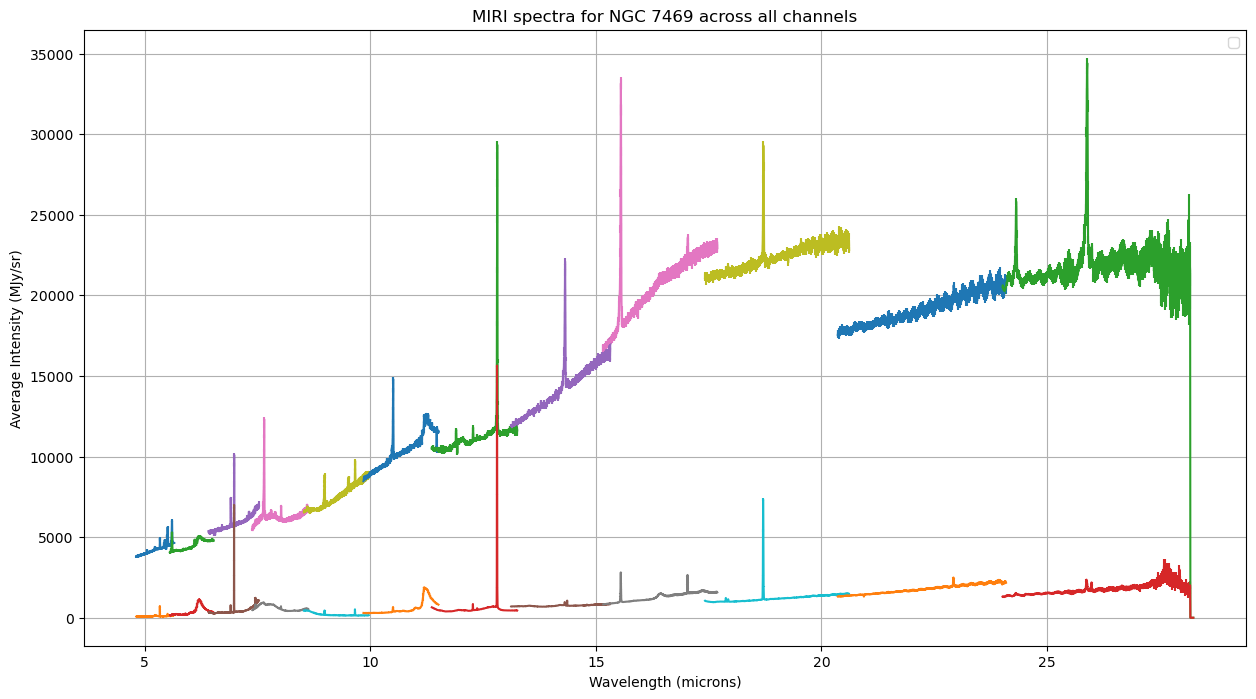

In [36]:
plt.figure(figsize=(15, 8))

channels = [1, 2, 3, 4]
parts = ['short', 'medium', 'long']

plt.title("MIRI spectra for NGC 7469 across all channels")

for ch in range(4):
    for part_idx, part in enumerate(parts):
        for region in range(2):
            idx = ch * 6 + part_idx * 2 + region
            plt.errorbar(
                wavelength_all[idx], 
                spectrum_all[idx], 
                yerr=spectrum_all_err[idx], 
                #label=f'Ch{ch+1}_{part}-Region {region}'
            )

plt.xlabel('Wavelength (microns)')
plt.ylabel('Average Intensity (MJy/sr)')
plt.grid(True)
plt.legend()



# Ploting only for Channel 1 with three different exposure(short, medium, long) having two regions in each of them

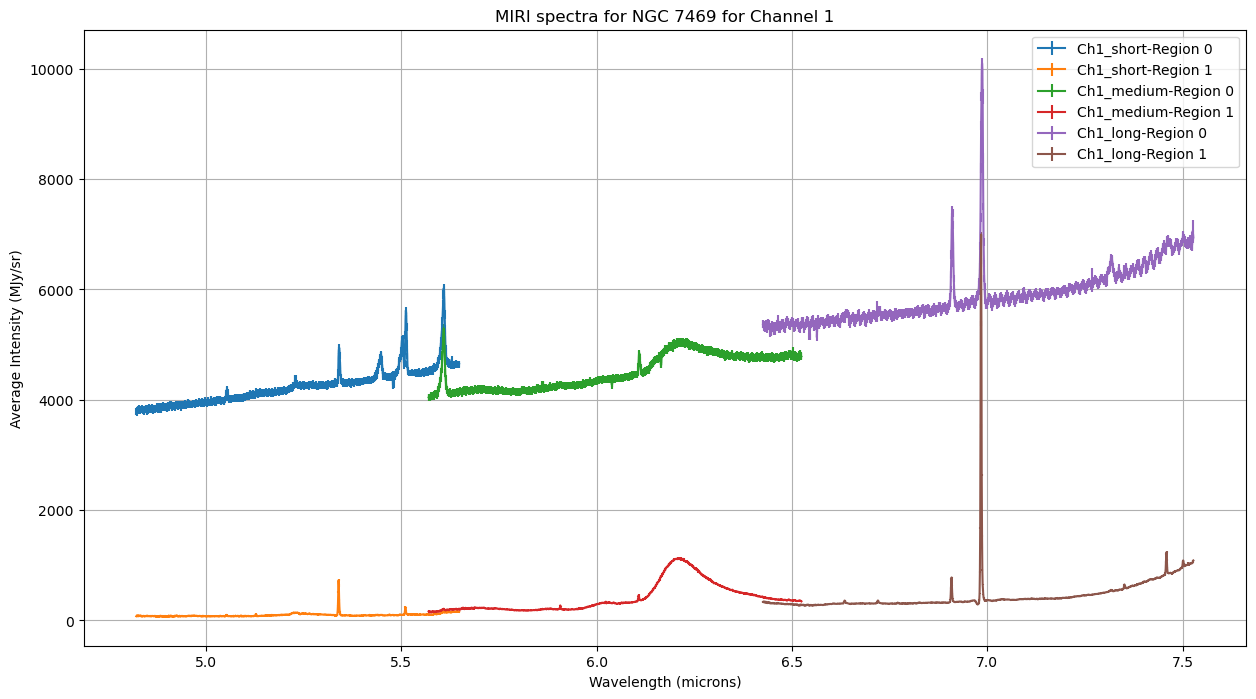

In [ ]:
plt.figure(figsize=(15, 8))

part1 =['short','medium','long'] #part1_index =0,1,2
ch =1
plt.title(f"MIRI spectra for NGC 7469 for Channel {ch}")

for part1_index, part in enumerate(part1):
    for region in range(2):
        j=(ch-1)*6 + part1_index*2 +region
        plt.errorbar(wavelength_all[j], spectrum_all[j], yerr=spectrum_all_err[j], label=f'Ch{ch}_{part}-Region {region}')

    
plt.xlabel('Wavelength (microns)')
plt.ylabel('Average Intensity (MJy/sr)')
plt.grid(True)
plt.legend()



Ploting for Ch1-short

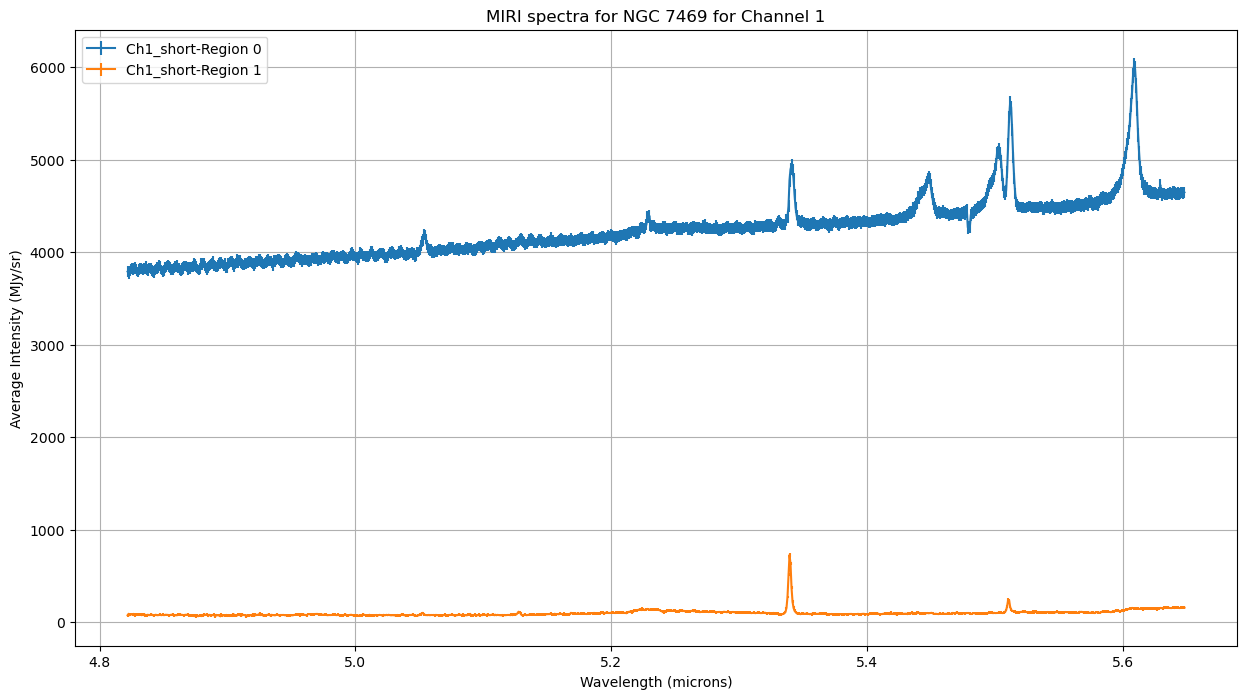

In [32]:
plt.figure(figsize=(15, 8))

part1 =['short'] #part1_index =0,1,2
ch =1
plt.title(f"MIRI spectra for NGC 7469 for Channel {ch}")

for part1_index, part in enumerate(part1):
    for region in range(2):
        j=(ch-1)*6 + part1_index*2 +region
        plt.errorbar(wavelength_all[j], spectrum_all[j], yerr=spectrum_all_err[j], label=f'Ch{ch}_{part}-Region {region}')

    
plt.xlabel('Wavelength (microns)')
plt.ylabel('Average Intensity (MJy/sr)')
plt.grid(True)
plt.legend()